# Traffic Quietness

**Author:** Haoyang Sun  
**Email:** has666@pitt.edu  
**Goal:** Compute a 0–1 “Traffic Quietness” score per Pittsburgh neighborhood (higher = quieter/safer) from DOMI’s most-recent traffic counts, and export a two-column file (`traffic.csv`) for the group composite.

## 1. Introduction
Our team determines the **best Pittsburgh neighborhood** using multiple metrics.  
This notebook is my **individual sub-metric**: **Traffic Quietness**. The intuition is that **lower traffic volume** and **less speeding** on residential streets improve safety, comfort, and ambient noise.

**Limitation:** DOMI retains only the **most recent** count per device; devices are placed for studies, so coverage is **not uniform**. Results are a **cross-section snapshot**, not long-term trends.


## 2. Setup
- Place the raw CSV **in the same folder** as this notebook.  
- Outputs will also be written **in the same folder**:
  - `traffic.csv` (two columns: `neighborhood,value`)
  - `traffic_top15.png` (Top-15 bar chart)


In [ ]:
from pathlib import Path
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

HERE = Path(".").resolve()

CSV_PATH = HERE / "traffic_count.csv"   

if not CSV_PATH.exists():
    cands = list(HERE.glob("*.csv"))
    CSV_PATH = next(
        (p for p in cands if any(k in p.name.lower() for k in ["traffic","count","domi"])),
        cands[0] if cands else None
    )

assert CSV_PATH and CSV_PATH.exists(), f"No CSV found next to the notebook. Looked in: {HERE}"
print("Using CSV:", CSV_PATH)

OUT_CSV = HERE / "traffic.csv"
OUT_PNG = HERE / "traffic_top15.png"

INCLUDE_BIKES = False 


Using CSV: /workspaces/final/Haoyang Sun/traffic_counts.csv


## 3. Load & Preview
We’ll load the dataset and preview key columns.


In [2]:
df = pd.read_csv(CSV_PATH)
df.columns = [c.strip() for c in df.columns]

expected = [
    "neighborhood",
    "average_daily_car_traffic",
    "percent_over_limit",
    "median_speed",
    "speed_limit",
]
print("Columns:", list(df.columns))
display(df.head(5)[[c for c in expected if c in df.columns]])


Columns: ['_id', 'id', 'device_id', 'record_oid', 'count_start_date', 'count_end_date', 'average_daily_car_traffic', 'average_daily_bike_traffic', 'counter_number', 'counter_type', 'speed_limit', 'max_speed', 'median_speed', 'percent_over_limit', 'speed85_percent', 'speed95_percent', 'longitude', 'latitude', 'neighborhood', 'council_district', 'ward', 'tract', 'public_works_division', 'pli_division', 'police_zone', 'fire_zone']


,neighborhood,average_daily_car_traffic,percent_over_limit,median_speed,speed_limit
0,Polish Hill,4949.0,77.0,29.0,25.0
1,Central Lawrenceville,NaN,NaN,NaN,NaN
2,Windgap,NaN,28.0,33.0,35.0
3,Squirrel Hill South,2741.0,70.0,28.0,25.0
4,Perry North,NaN,NaN,NaN,NaN


## 4. Cleaning & Aggregation
- Coerce numeric fields
- Define **volume = average_daily_car_traffic** 
- Drop rows without car volume
- Aggregate to **neighborhood** with **median** 


In [ ]:
NEI = "neighborhood"
CAR = "average_daily_car_traffic"
OVP = "percent_over_limit"
MS  = "median_speed"
SL  = "speed_limit"

for c in [CAR, OVP, MS, SL]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df["_volume_raw"] = df[CAR]

dat = df[[NEI, "_volume_raw", OVP, MS, SL]].copy()

before = len(dat)
dat = dat.dropna(subset=["_volume_raw"])
print(f"Dropped {before - len(dat)} rows with missing car volume.")

agg = {c: "median" for c in dat.columns if c != NEI}
g = dat.groupby(NEI, as_index=False).agg(agg).rename(columns={NEI: "neighborhood"})

g["overspeed_raw"] = np.where(
    g.get(OVP).notna() if OVP in g.columns else False,
    g[OVP],
    np.where(
        (MS in g.columns) & (SL in g.columns) and (g[MS].notna() & g[SL].notna()),
        (g[MS] - g[SL]).clip(lower=0),
        np.nan
    )
) if OVP in g.columns or (MS in g.columns and SL in g.columns) else np.nan

print("Neighborhoods after clean:", len(g))
print("Missing overspeed_raw:", int(pd.isna(g["overspeed_raw"]).sum()))
display(g.head())


Dropped 134 rows with missing car volume.
Neighborhoods after clean: 64
Missing overspeed_raw: 2


,neighborhood,_volume_raw,percent_over_limit,median_speed,speed_limit,overspeed_raw
0,Allegheny Center,2386.0,65.0,27.0,25.0,65.0
1,Allegheny West,477.0,11.0,20.0,25.0,11.0
2,Arlington,2285.5,61.5,26.5,25.0,61.5
3,Beechview,1446.0,72.0,28.0,25.0,72.0
4,Beltzhoover,1577.0,NaN,23.0,NaN,NaN


## 5. Method

**Fields used**
- `average_daily_car_traffic` (lower = better)
- `percent_over_limit` (fallback: `(median_speed − speed_limit)+`)
- `neighborhood`

**Scoring**

Let \(V_n\) be neighborhood median **car volume**; let \(S_n\) be the overspeed proxy.

$$
\text{vol\_score}_n = 1 - \frac{V_n - \min(V)}{\max(V) - \min(V)}, \qquad
\text{speed\_score}_n = 1 - \frac{S_n - \min(S)}{\max(S) - \min(S)}.
$$

Combine with \(w_V=0.7,\, w_S=0.3\):

$$
\text{quietness}_n = 0.7 \cdot \text{vol\_score}_n + 0.3 \cdot \text{speed\_score}_n.
$$

*(If overspeed is missing for a neighborhood, the score falls back to the volume component only.)*


## 6. Scoring — Normalize & Combine

In [ ]:
def inv_minmax(s: pd.Series) -> pd.Series:
    s = s.astype(float)
    if s.max() == s.min():
        return pd.Series(1.0, index=s.index)
    return 1 - (s - s.min())/(s.max() - s.min())

g["volume_score"] = inv_minmax(g["_volume_raw"])

if pd.notna(g["overspeed_raw"]).any():
    s = g["overspeed_raw"]
    mask = s.notna()
    sr = pd.Series(index=g.index, dtype=float)
    sr.loc[mask] = inv_minmax(s.loc[mask]).values
    g["speed_risk_score"] = sr
else:
    g["speed_risk_score"] = np.nan

g["value"] = g["volume_score"]
mask = g["speed_risk_score"].notna()
g.loc[mask, "value"] = 0.7*g.loc[mask, "volume_score"] + 0.3*g.loc[mask, "speed_risk_score"]

quiet = g[["neighborhood","value"]].sort_values("value", ascending=False).reset_index(drop=True)
display(quiet)
print("Total neighborhoods:", len(quiet), "| value range:", float(quiet["value"].min()), "→", float(quiet["value"].max()))


,neighborhood,value
0,South Side Flats,0.996875
1,Central Northside,0.967895
2,Lincoln Place,0.962037
3,Allegheny West,0.956623
4,Lincoln-Lemington-Belmar,0.943504
...,...,...
59,Westwood,0.500733
60,East Hills,0.420263
61,North Shore,0.331267
62,Crafton Heights,0.220314


Total neighborhoods: 64 | value range: 0.0375 → 0.996875


## 7. Results — Top 15

PosixPath('/workspaces/final/Haoyang Sun/traffic_top15.png')

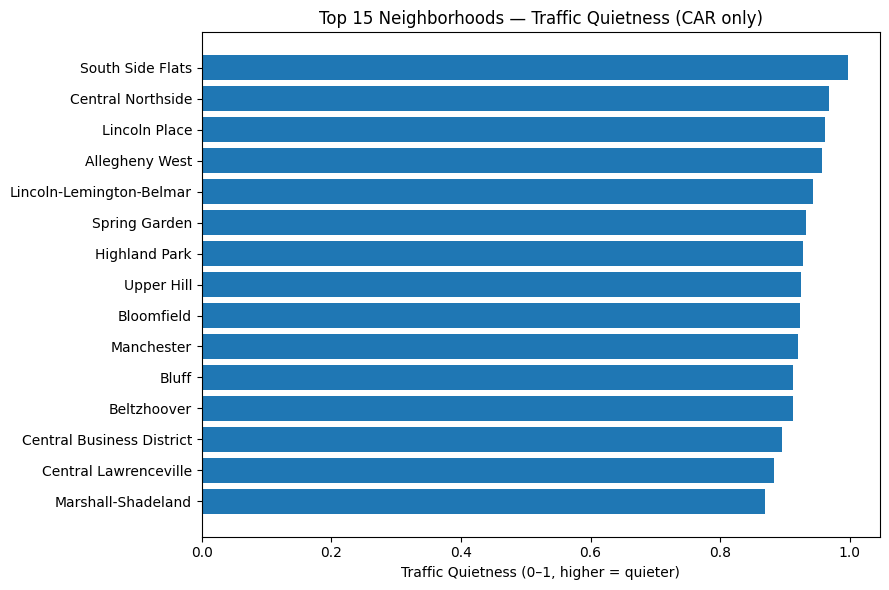

In [5]:
plt.figure(figsize=(9,6))
topk = quiet.head(15)  # change to quiet for all, or head(50) for top 50
plt.barh(topk["neighborhood"][::-1], topk["value"][::-1])
plt.xlabel("Traffic Quietness (0–1, higher = quieter)")
plt.title("Top 15 Neighborhoods — Traffic Quietness (CAR only)")
plt.tight_layout()
plt.savefig(OUT_PNG, dpi=200)
OUT_PNG

## 8. Deliverable — Export two-column table
The file below is consumed by our group’s combined notebook.


In [ ]:
quiet.to_csv(OUT_CSV, index=False)
OUT_CSV, quiet.shape

(PosixPath('/workspaces/final/Haoyang Sun/traffic.csv'), (64, 2))

## 9. Component contributions (top 15)

In [7]:
cols = ["neighborhood"]
if "volume_score" in g: cols.append("volume_score")
if "speed_risk_score" in g: cols.append("speed_risk_score")
cols.append("value")

contrib = g[cols].sort_values("value", ascending=False).head(15).reset_index(drop=True)
contrib


,neighborhood,volume_score,speed_risk_score,value
0,South Side Flats,1.000000,0.989583,0.996875
1,Central Northside,0.954135,1.000000,0.967895
2,Lincoln Place,0.999338,0.875000,0.962037
3,Allegheny West,0.978211,0.906250,0.956623
4,Lincoln-Lemington-Belmar,0.995185,0.822917,0.943504
5,Spring Garden,0.933129,NaN,0.933129
6,Highland Park,0.981582,0.802083,0.927732
7,Upper Hill,0.951126,0.864583,0.925163
8,Bloomfield,0.945829,0.869792,0.923018
9,Manchester,0.971771,0.802083,0.920865


## 10. Conclusion (Individual)

Based on the `traffic.csv` produced by this notebook —  Traffic Quietness metric that inversely normalizes car volume and adds an overspeed component (combined at 0.7/0.3) — the quietest neighborhoods in our dataset are **South Side Flats** (rank #1), **Lincoln Place** (#2), **Allegheny West** (#3), **Highland Park** (#4), and **Central Northside** (#5). Scores are on a 0–1 scale where higher means quieter.

This two-column file (`neighborhood,value`) will be used directly in our team’s composite metric for determining the overall “best neighborhood.” 

*Limitations.* Results reflect a snapshot (most-recent counts) and non-uniform device placement focused on study locations; where overspeed data were missing, the score falls back to the volume component, which can slightly favor low-volume areas.
